## Melanoma Detection Asssignment

## Problem Statement

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset from Internation Skin Imaging Collaboration (ISIC) contains of 2357 images of maliagnment and benign oncology diseases. All images are sorted according to the classification with ISIC.


The data set contains of the following diseases

       Actinic keratosis
       Basal cell carcinoma
       Dermatofibroma
       Melanom
       Nevus
       Pigmented benign keratosis
       Seborrheic keratosis
       Squamous cell carcinoma
       Vascular lesion

## Steps

Main aim of this will be to classify the images accuractly. Following steps will be taken to achieve that

    1.Examine and understand data
    2. Build an input pipeline
    3. Build the model
    4. Train the model
    5. Test the model 
    6. Improve the model

### Importing all the important libraries

In [88]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img

In [89]:
## Data is initially downloaded and kept in the google drive so connect to google drive first
from google.colab import drive
drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [90]:
#Since the data is downloaded in .zip format it will need to unzipped and kept in a folder
#!unzip /content/gdrive/MyDrive/CNN_assignment.zip -d /content/gdrive/MyDrive

In [91]:
#checking the GPU connection
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jan 18 00:42:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    30W /  70W |   1910MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [92]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [93]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [94]:
batch_size = 32
img_height = 180
img_width = 180

As part of the general good practice 80% of the images for training, and 20% for validation.

In [95]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [96]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


Using the code below we can look at the class_names associated on the dataset. these can be directory names.

In [97]:

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

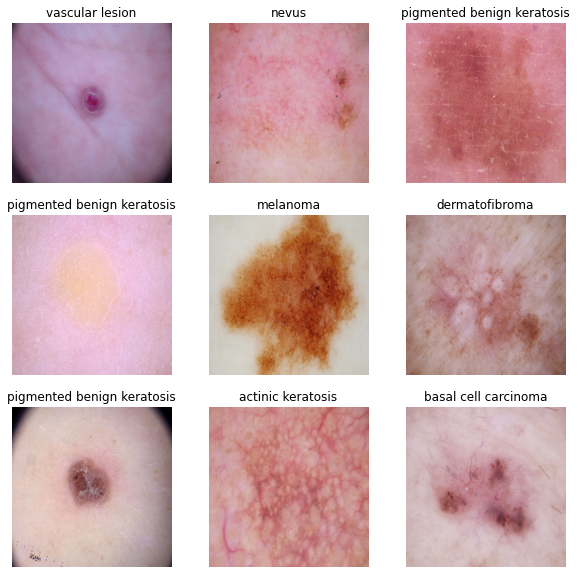

In [98]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [99]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

### Data Augmentation

In [100]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(180, 
                                                              180,
                                                              3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

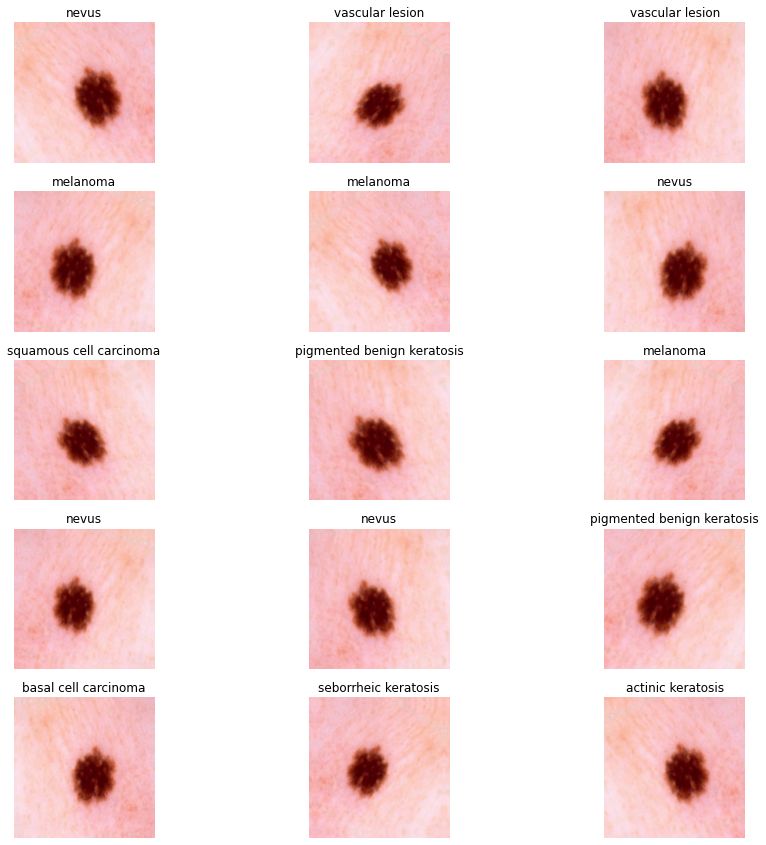

In [101]:
plt.figure(figsize=(15, 15))
for images, label in train_ds.take(1):
    for i in range(15):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(5, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

In [102]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [103]:
## You can use Dropout layer if there is an evidence of overfitting in your findings


model = data_augmentation
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3))) 
# Increse the model size by adding another 32 layer
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))



### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [104]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [105]:
# View the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_4 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_4 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_4 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_50 (ModuleWr  (None, 180, 180, 16)     448       
 apper)                                                          
                                                                 
 module_wrapper_51 (ModuleWr  (None, 90, 90, 16)      

### Train the model

In [106]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 17s 95ms/step - loss: 1.9308 - accuracy: 0.2874 - val_loss: 1.7294 - val_accuracy: 0.3736
Epoch 2/20
56/56 [==============================] - 2s 42ms/step - loss: 1.7993 - accuracy: 0.3532 - val_loss: 1.6766 - val_accuracy: 0.3736
Epoch 3/20
56/56 [==============================] - 2s 41ms/step - loss: 1.7041 - accuracy: 0.3767 - val_loss: 1.5780 - val_accuracy: 0.4273
Epoch 4/20
56/56 [==============================] - 2s 41ms/step - loss: 1.6860 - accuracy: 0.3973 - val_loss: 1.5703 - val_accuracy: 0.4720
Epoch 5/20
56/56 [==============================] - 2s 41ms/step - loss: 1.6718 - accuracy: 0.4074 - val_loss: 1.5851 - val_accuracy: 0.4653
Epoch 6/20
56/56 [==============================] - 2s 41ms/step - loss: 1.6531 - accuracy: 0.4157 - val_loss: 1.5218 - val_accuracy: 0.4541
Epoch 7/20
56/56 [==============================] - 2s 42ms/step - loss: 1.5993 - accuracy: 0.4369 - val_loss: 1.4612 - val_accuracy: 0.4877
Epoch 8/20
5

### Visualizing training results

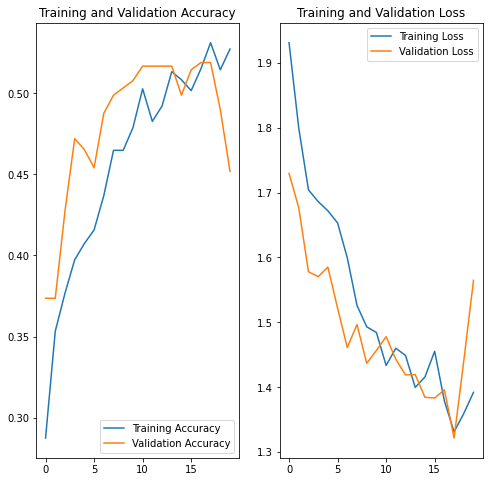

In [107]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings

As we can see from the image above the model isnt learning as well and can see a overfitting. One of the reason model isnt training well could be due to class imbalance. Class imbalance on a image classficiation could lead to the similar issues seen above. The reason that the data did not overfitt much in this model is due to the Dropout introduced in the model, which drops out 20% of the output units randomly from the data.

In [111]:
class_imbalance = {}

for name in class_names:
    class_imbalance[name] = len(list(data_dir_train.glob(name+'/*.jpg')))
    
class_imbalance

{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

In [112]:
imbalance_df = pd.DataFrame(class_imbalance.items(),index=list(class_imbalance), columns = ['Name', 'Sample'])
imbalance_df.drop(['Name'], axis = 1, inplace=True)
imbalance_df

,Sample
actinic keratosis,114
basal cell carcinoma,376
dermatofibroma,95
melanoma,438
nevus,357
pigmented benign keratosis,462
seborrheic keratosis,77
squamous cell carcinoma,181
vascular lesion,139


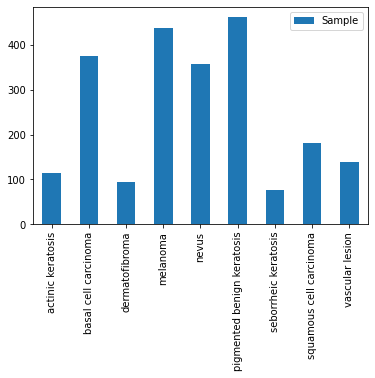

In [110]:
imbalance_df.plot.bar()
plt.show()

 Write your findings here:
- Which class has the least number of samples? seborrhelc keratosis got the lowest samples
- Which classes dominate the data in terms proportionate number of samples? pigmented benign keratosis is dominate the classes

As we can see that there a clear imbalance in the data, this needs to be sorted out to fix learning issue seen above


### Class Imbalance Rectification Using Augmentor


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

!pip install Augmentor

In [ ]:
path_to_training_dataset="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory='/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Augmented/' +i +'/Output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000)

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F82D67C3F40>: 100%|██████████| 1000/1000 [00:38<00:00, 25.65 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8360E54610>: 100%|██████████| 1000/1000 [00:35<00:00, 27.86 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F82D67F4580>: 100%|██████████| 1000/1000 [00:35<00:00, 28.37 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F82E353C1F0>: 100%|██████████| 1000/1000 [02:47<00:00,  5.97 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7F8360DF9430>: 100%|██████████| 1000/1000 [02:30<00:00,  6.63 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F82D6694EB0>: 100%|██████████| 1000/1000 [00:35<00:00, 28.01 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F838E947190>: 100%|██████████| 1000/1000 [01:21<00:00, 12.26 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F82E23301F0>: 100%|██████████| 1000/1000 [00:35<00:00, 28.19 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F82E2415370>: 100%|██████████| 1000/1000 [00:37<00:00, 26.45 Samples/s]


In [113]:
output_dir= pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Augmented/")

In [114]:
image_count_train = len(list(output_dir.glob('*/Output/*.jpg')))
print(image_count_train)

9000


### Training Model using Augmentor

In [115]:
train_ds1 =  tf.keras.preprocessing.image_dataset_from_directory(
    output_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 7200 files for training.


In [116]:
val_ds1 = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 1800 files for validation.


In [117]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds1 = train_ds1.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds1 = val_ds1.cache().prefetch(buffer_size=AUTOTUNE)

In [118]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(180, 
                                                              180,
                                                              3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

### Creating Model 

In [119]:
model = data_augmentation
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3))) 
# Increse the model size by adding another 32 layer
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))


### Compliling the Model

In [120]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the Model

In [121]:
epochs = 30
history = model.fit(
  train_ds1,
  validation_data=val_ds1,
  epochs=epochs
)

Epoch 1/30
225/225 [==============================] - 39s 63ms/step - loss: 1.7250 - accuracy: 0.3371 - val_loss: 1.4876 - val_accuracy: 0.3922
Epoch 2/30
225/225 [==============================] - 9s 41ms/step - loss: 1.4284 - accuracy: 0.4489 - val_loss: 1.5266 - val_accuracy: 0.4439
Epoch 3/30
225/225 [==============================] - 9s 41ms/step - loss: 1.3046 - accuracy: 0.4919 - val_loss: 1.3436 - val_accuracy: 0.5072
Epoch 4/30
225/225 [==============================] - 10s 45ms/step - loss: 1.2589 - accuracy: 0.5196 - val_loss: 1.4965 - val_accuracy: 0.4561
Epoch 5/30
225/225 [==============================] - 9s 42ms/step - loss: 1.1897 - accuracy: 0.5431 - val_loss: 1.1263 - val_accuracy: 0.5700
Epoch 6/30
225/225 [==============================] - 9s 42ms/step - loss: 1.1174 - accuracy: 0.5774 - val_loss: 1.1411 - val_accuracy: 0.5789
Epoch 7/30
225/225 [==============================] - 9s 42ms/step - loss: 1.0870 - accuracy: 0.5829 - val_loss: 1.0723 - val_accuracy: 0.61

### Visualising the Model

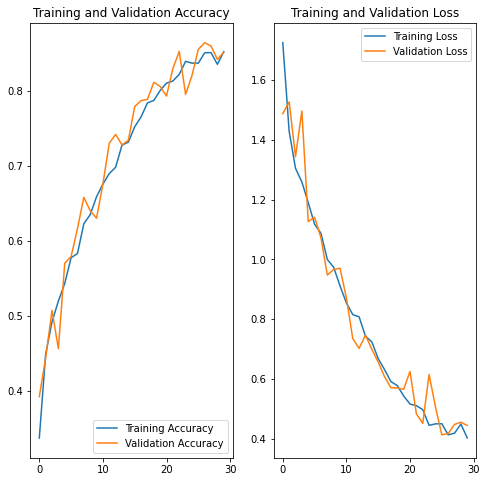

In [122]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model Evaluation

1/1 [==============================] - 0s 77ms/step
Actual Class basal cell carcinoma
Predictive Class dermatofibroma


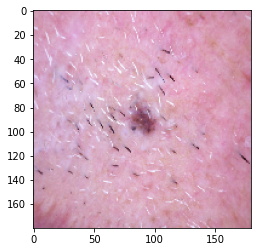

In [123]:
from glob import glob
test_path = os.path.join(data_dir_test, class_names[1], '*')
test_img = glob(test_path)
test_img = load_img(test_img[8],target_size=(180,180,3))
plt.imshow(test_img)
plt.grid(False)

img = np.expand_dims(test_img,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

####  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Overfitting was initially controlled by drop out due data imabalance model found it hard to learn much from the data, by doing additional augmentation using Augmentor on the second model made a big difference to the model.